In [156]:
import os
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from glob import glob

from pandas_profiling import ProfileReport # profile report を作る用

import xfeat
from xfeat import (ArithmeticCombinations, ConcatCombination,
                   GBDTFeatureExplorer, GBDTFeatureSelector, LabelEncoder,
                   LambdaEncoder, Pipeline, SelectCategorical, SelectNumerical,
                   TargetEncoder, aggregation)

In [276]:
# train_df=pd.read_csv('/work/inputs/train.csv', converters={'間取り':str})
test_df_ori=pd.read_csv('/work/inputs/test.csv')
sub_df=pd.read_csv('/work/inputs/sample_submission.csv')

paths = glob('/work/inputs/train/*')
train_dfs = []
for path in paths:
    train_df_ori = pd.read_csv(path)
    train_dfs.append(train_df_ori)
train_df_ori = pd.concat(train_dfs)
train_df_ori.reset_index(drop=True, inplace=True)

In [290]:
test_df_ori.shape

(19466, 27)

In [158]:
INPUT_DIR = '/work/inputs/'
OUTPUT_DIR = '/work/outputs/'

os.makedirs(OUTPUT_DIR, exist_ok=True)

## 前処理

In [284]:
train_df = train_df_ori.copy()
test_df = test_df_ori.copy()

In [285]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
rm_cols = []

test_df[TARGET] = np.nan
df = pd.concat([train_df, test_df])

In [249]:
def delete_col(input_df):
    rm_cols = []
    rm_cols += ['市区町村コード']
    for i, v in input_df.nunique().iteritems():
        if v <= 1:
            rm_cols.append(i)
    return input_df.drop(rm_cols, axis=1, inplace=True)

In [163]:
# def create_building_year(input_df):
#     def convert_wareki_to_seireki(wareki):
#         if wareki == wareki:
#             if wareki == '戦前':
#                 wareki = '昭和20年'
#             value = wareki[2:-1]
#             if value == '元':
#                 value = 1
#             else:
#                 value = int(value)
#             if '昭和' in wareki:
#                 seireki = 1925+value
#             elif '平成' in wareki:
#                 seireki = 1988+value
#             elif '令和' in wareki:
#                 seireki = 2018+value
#         else:
#             seireki = wareki
#         return seireki
#     use_columns = [
#         '建築年'
#     ]
#     out_df = pd.DataFrame()
#     for column in use_columns:
#         out_df['建築年'] = input_df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
#     return out_df

In [164]:
def create_building_year(input_df):
    def convert_wareki_to_seireki(wareki):
        if wareki == wareki:
            if wareki == '戦前':
                wareki = '昭和20年'
            value = wareki[2:-1]
            if value == '元':
                value = 1
            else:
                value = int(value)
            if '昭和' in wareki:
                seireki = 1925+value
            elif '平成' in wareki:
                seireki = 1988+value
            elif '令和' in wareki:
                seireki = 2018+value
        else:
            seireki = wareki
        return seireki
    use_columns = [
        '建築年'
    ]
    for column in use_columns:
        input_df['建築年_to_seireki'] = input_df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
    return input_df

In [165]:
def create_minutes_from_station(input_df):
    def normalize_moyori(moyori):
        if moyori == moyori:
            if moyori == '30分?60分':
                moyori = 45
            elif moyori == '1H?1H30':
                moyori = 75
            elif moyori == '1H30?2H':
                moyori = 105
            elif moyori == '2H?':
                moyori = 120
            moyori = int(moyori)
        return moyori
    use_columns = [
        '最寄駅：距離（分）'
    ]
    out_df = pd.DataFrame()
    for column in use_columns:
        input_df[column] = input_df[column].apply(lambda x: normalize_moyori(x))
    return input_df

In [166]:
def create_squre(input_df):
    def normalize_area(area):
        if area == area:
            area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
        return area
    use_columns = [
        '面積（㎡）'
    ]
    out_df = pd.DataFrame()
    for column in use_columns:
        input_df[column] = input_df[column].apply(lambda x: normalize_area(x))
    return input_df

In [286]:

delete_col(train_df)
create_building_year(train_df)
# create_minutes_from_station(train_df)
# create_squre(train_df)

delete_col(test_df)
create_building_year(test_df)
# create_minutes_from_station(test_df)
# create_squre(test_df)

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,建築年_to_seireki
0,1000000,北海道,札幌市中央区,旭ケ丘,円山公園,26,３ＬＤＫ,75,昭和64年,ＲＣ,NaN,住宅,第１種低層住居専用地域,40.0,60.0,2020年第２四半期,未改装,NaN,1989.0
1,1000056,北海道,札幌市中央区,大通西,西１１丁目,1,２ＬＤＫ,55,平成28年,ＲＣ,NaN,住宅,商業地域,80.0,600.0,2020年第１四半期,未改装,NaN,2016.0
2,1000108,北海道,札幌市中央区,大通西,西１８丁目,2,１Ｒ,15,昭和64年,ＳＲＣ,NaN,住宅,商業地域,80.0,400.0,2020年第２四半期,未改装,NaN,1989.0
3,1000109,北海道,札幌市中央区,大通西,西１８丁目,2,１ＬＤＫ,45,平成3年,ＳＲＣ,NaN,住宅,商業地域,80.0,400.0,2020年第２四半期,改装済,NaN,1991.0
4,1000110,北海道,札幌市中央区,大通西,西１８丁目,3,１Ｒ,20,昭和56年,ＲＣ,NaN,住宅,商業地域,80.0,400.0,2020年第２四半期,NaN,NaN,1981.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19461,47003828,沖縄県,浦添市,牧港,NaN,NaN,４ＬＤＫ,80,平成31年,ＲＣ,住宅,住宅,商業地域,80.0,400.0,2020年第１四半期,未改装,NaN,2019.0
19462,47003829,沖縄県,浦添市,牧港,NaN,NaN,２ＬＤＫ,70,平成10年,ＲＣ,NaN,住宅,準工業地域,60.0,200.0,2020年第１四半期,改装済,NaN,1998.0
19463,47003880,沖縄県,浦添市,港川,NaN,NaN,４ＬＤＫ,50,平成12年,ＳＲＣ,住宅,住宅,第１種中高層住居専用地域,60.0,200.0,2020年第１四半期,未改装,NaN,2000.0
19464,47006648,沖縄県,沖縄市,与儀,NaN,NaN,３ＬＤＫ,60,平成31年,ＲＣ,住宅,住宅,市街化区域及び市街化調整区域外の都市計画区域,70.0,200.0,2020年第１四半期,未改装,NaN,2019.0


In [239]:
create_building_year(df)
create_minutes_from_station(df)
create_squre(df)

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,...,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,建築年_to_seireki
0,1060685,中古マンション等,NaN,1108,北海道,札幌市厚別区,大谷地東,大谷地,8.0,３ＬＤＫ,...,NaN,NaN,準工業地域,60.0,200.0,2009年第４四半期,未改装,NaN,7.079181,1995.0
1,1005580,中古マンション等,NaN,1101,北海道,札幌市中央区,南９条西,中島公園,5.0,１ＤＫ,...,NaN,NaN,近隣商業地域,80.0,300.0,2018年第３四半期,未改装,NaN,6.755875,1982.0
2,1001363,中古マンション等,NaN,1101,北海道,札幌市中央区,北３条西,西１１丁目,11.0,３ＬＤＫ,...,NaN,NaN,近隣商業地域,80.0,300.0,2010年第２四半期,未改装,NaN,7.204120,1991.0
3,1052374,中古マンション等,NaN,1108,北海道,札幌市厚別区,厚別中央２条,ひばりが丘(北海道),5.0,４ＬＤＫ,...,NaN,NaN,商業地域,80.0,400.0,2015年第３四半期,未改装,NaN,7.591065,2015.0
4,1059107,中古マンション等,NaN,1108,北海道,札幌市厚別区,厚別東４条,新さっぽろ,12.0,４ＬＤＫ,...,NaN,NaN,準工業地域,60.0,200.0,2012年第４四半期,未改装,NaN,6.875061,1982.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19461,47003828,中古マンション等,NaN,47208,沖縄県,浦添市,牧港,NaN,NaN,４ＬＤＫ,...,NaN,NaN,商業地域,80.0,400.0,2020年第１四半期,未改装,NaN,NaN,2019.0
19462,47003829,中古マンション等,NaN,47208,沖縄県,浦添市,牧港,NaN,NaN,２ＬＤＫ,...,NaN,NaN,準工業地域,60.0,200.0,2020年第１四半期,改装済,NaN,NaN,1998.0
19463,47003880,中古マンション等,NaN,47208,沖縄県,浦添市,港川,NaN,NaN,４ＬＤＫ,...,NaN,NaN,第１種中高層住居専用地域,60.0,200.0,2020年第１四半期,未改装,NaN,NaN,2000.0
19464,47006648,中古マンション等,NaN,47211,沖縄県,沖縄市,与儀,NaN,NaN,３ＬＤＫ,...,NaN,NaN,市街化区域及び市街化調整区域外の都市計画区域,70.0,200.0,2020年第１四半期,未改装,NaN,NaN,2019.0


In [287]:
test_df.shape

(19466, 19)

In [288]:
train_df.shape

(637351, 20)

## 特徴量生成

In [168]:
#これをするとdropした後のcolumを残すことになり特徴量に文字が入ってしまうので注意。
def create_enc(input_df):
    use_columns = [
        '取引時点'
    ]
    out_df = pd.DataFrame()
    for column in use_columns:
        enc_dic = {}
        for i, e in enumerate(sorted(list(set(input_df[column].values)))):
            enc_dic[e] = i
        out_df[column]=input_df[column].map(enc_dic)
    return out_df.add_suffix('_enc')

In [169]:
def  create_target_todoufu(input_df):
    use_columns = [
        '都道府県名',
        '取引価格（総額）_log',
        '取引時点'
    ]
    out_df = pd.DataFrame()
    hoge_df = input_df[use_columns]
    hoge_df = pd.concat([hoge_df,create_enc(hoge_df)],axis=1)
    te_dic = {}
    TARGET = '取引価格（総額）_log'
    time_col = '取引時点_enc'
    group_col = '都道府県名'
    for i in set(hoge_df[time_col].values):
        tmp_df = hoge_df[hoge_df[time_col] < i]
        te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()
    def calc_te(row):
        if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
            return te_dic[row[time_col]][row[group_col]]
        else:
            return 0
    out_df[group_col+'_te'] = hoge_df.apply(calc_te, axis=1)
    return out_df

In [170]:
def create_agg(input_df):
    agg_dfs = []
#     agg_dfs = pd.DataFrame()
    def get_agg_df(df, group_col):
        agg_df, agg_cols = aggregation(df,
                                       group_key=group_col,
                                       # '前面道路：幅員（ｍ）',
                                       group_values=['最寄駅：距離（分）',
                                                     '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
                                       agg_methods=['count', 'mean', 'min', 'max'],
                                       )
        return agg_df[agg_cols]
    group_col = '市区町村名'
    return get_agg_df(input_df,group_col)

In [171]:
#これをするとdropした後のcolumを残すことになり特徴量に文字が入ってしまうので注意。
def years_ago(input_df):
    use_columns = [
        '取引時点'
    ]
    out_df = pd.DataFrame()
    for column in use_columns:
        out_df[column]=input_df[column].apply(lambda x: 2020-int(x[:4]))
    return out_df.add_suffix('_何年前')

In [172]:
def create_squre_times_volumes(input_df):
    encoder = Pipeline(
        [
            SelectNumerical(),
            ArithmeticCombinations(
                input_cols=["面積（㎡）", "容積率（％）"],
                drop_origin=True,
                operator="*",
                r=2,
            ),
        ]
    )
    out_df = encoder.fit_transform(input_df)/100
    return out_df.add_suffix('_squre_squre_times_volumes')

In [173]:
# def create_one_hot_encoding_nenngou(input_df):
#     use_columns = [
#         '建築年'
#     ]
#     out_df = pd.DataFrame()
#     for column in use_columns:
#         out_df['建築年_令和'] = input_df[column].str.contains('令和')*1
#         out_df['建築年_平成'] = input_df[column].str.contains('平成')*1
#         out_df['建築年_昭和'] = input_df[column].str.contains('昭和')*1
#         out_df['建築年_戦前'] = input_df[column].str.contains('戦前')*1
#     return out_df.add_prefix('nengo_')

In [235]:
def create_num_data(input_df):
    out_df = pd.DataFrame()
    out_df = SelectNumerical().fit_transform(input_df)
    return out_df

In [236]:
def create_label_encoding(input_df):
    encoder = Pipeline([
        SelectCategorical(),
        LabelEncoder(output_suffix=""),
    ])
    return encoder.fit_transform(input_df)

In [176]:
# def create_one_hot_encoding(input_df):
#     use_columns = [
#         '都道府県名',
#         '市区町村名',
#         '建築年',
#         '建物の構造',
#         '用途',
#         '都市計画',
#         '取引時点',
#         '改装',
#         '取引の事情等'
#     ]
#     out_df = pd.DataFrame()
#     for column in use_columns:
        
#         # あまり巨大な行列にならないよう, 出現回数が 20 回を下回るカテゴリは考慮しない
#         vc = train_df[column].value_counts()
#         vc = vc[vc > 10000]
        
#         # 明示的に catgories を指定して, input_df によらず列の大きさが等しくなるようにする
#         cat = pd.Categorical(input_df[column], categories=vc.index)
        
#         # このタイミングで one-hot 化
#         out_i = pd.get_dummies(cat)
#         # column が Catgory 型として認識されているので list にして解除する (こうしないと concat でエラーになる)
#         out_i.columns = out_i.columns.tolist()
#         out_i = out_i.add_prefix(f'{column}=')
#         out_df = pd.concat([out_df, out_i], axis=1)
#     return out_df

In [177]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [237]:
from tqdm import tqdm

def to_feature(input_df):
    """input_df を特徴量行列に変換した新しいデータフレームを返す.
    """
    
    processors = [
        create_enc,
        create_target_todoufu,
        create_agg,
        years_ago,
        create_squre_times_volumes,
#       encodingする際にtrainとtestを共通のencogingにしてないとerror
        create_num_data,
        create_label_encoding
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)
        
        # 長さが等しいことをチェック (ずれている場合, func の実装がおかしい)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [238]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

 14%|█▍        | 1/7 [00:00<00:00,  6.51it/s]

createcreate_enc  0.152[s]


 29%|██▊       | 2/7 [00:34<01:40, 20.08s/it]

createcreate_target_todoufu  34.026[s]


 43%|████▎     | 3/7 [00:40<00:55, 13.77s/it]

createcreate_agg  6.237[s]


 57%|█████▋    | 4/7 [00:41<00:25,  8.59s/it]

createyears_ago  0.602[s]
createcreate_squre_times_volumes  0.039[s]
createcreate_num_data  0.010[s]


  0%|          | 0/7 [00:00<?, ?it/s]

createcreate_label_encoding  3.377[s]
createcreate_enc  0.020[s]


 29%|██▊       | 2/7 [00:01<00:02,  1.71it/s]

createcreate_target_todoufu  1.148[s]


 71%|███████▏  | 5/7 [00:01<00:00,  3.48it/s]

createcreate_agg  0.217[s]
createyears_ago  0.018[s]
createcreate_squre_times_volumes  0.008[s]
createcreate_num_data  0.010[s]


AssertionError: create_num_data

In [ ]:
test_feat_df.shape

In [181]:
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} MAE: {mean_absolute_error(y_valid, pred_i):.4f}')

    score = mean_absolute_error(y, oof_pred)
    print('-' * 50)
    print('FINISHED | Whole MAE: {:.4f}'.format(score))
    return oof_pred, models

In [182]:
params = {
#     # 目的関数. これの意味で最小となるようなパラメータを探します. 
#     'objective': 'regression_l1', 
    
#     # 目的関数. これの意味で最小となるようなパラメータを探します. 
#     'metric': 'mae',
    
#      # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
#     # がそれだけ木を作るため学習に時間がかかります
#     'learning_rate': .1,
    
#     # L2 Reguralization
#     'reg_lambda': 1.,
#     # こちらは L1 
#     'reg_alpha': .1,
    
#     # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
#     'max_depth': 5, 
    
#     # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
#     'n_estimators': 10000, 
    
#     # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
#     'colsample_bytree': .5, 
    
#     # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
#     'min_child_samples': 10,
    
#     # bagging の頻度と割合
#     'subsample_freq': 3,
#     'subsample': .9,
    
#     # 特徴重要度計算のロジック(後述)
#     'importance_type': 'gain', 
#     'random_state': 71,
    
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
    
}

In [183]:
y = train_df['取引価格（総額）_log'].values

In [184]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=50000, num_boost_round=50000 will be ignored. Current value: num_iterations=50000
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
Training until validation scores don't improve for 100 rounds


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 0.00394733
[1000]	valid_0's l1: 0.00326858
[1500]	valid_0's l1: 0.00293129
[2000]	valid_0's l1: 0.00272017
[2500]	valid_0's l1: 0.00254657
[3000]	valid_0's l1: 0.0024195
[3500]	valid_0's l1: 0.00231048
[4000]	valid_0's l1: 0.00222284
[4500]	valid_0's l1: 0.0021457
[5000]	valid_0's l1: 0.00208616
[5500]	valid_0's l1: 0.00203946
[6000]	valid_0's l1: 0.00199457
[6500]	valid_0's l1: 0.00195944
[7000]	valid_0's l1: 0.00192531
[7500]	valid_0's l1: 0.00189584
[8000]	valid_0's l1: 0.00186976
[8500]	valid_0's l1: 0.00184428
[9000]	valid_0's l1: 0.00182245
[9500]	valid_0's l1: 0.00180114
[10000]	valid_0's l1: 0.00178367
[10500]	valid_0's l1: 0.00176785
[11000]	valid_0's l1: 0.00175277
[11500]	valid_0's l1: 0.00174013
[12000]	valid_0's l1: 0.00172659
[12500]	valid_0's l1: 0.00171496
[13000]	valid_0's l1: 0.00170427
[13500]	valid_0's l1: 0.00169435
[14000]	valid_0's l1: 0.00168523
[14500]	valid_0's l1: 0.00167679
[15

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 0.00397275
[1000]	valid_0's l1: 0.00332098
[1500]	valid_0's l1: 0.00297081
[2000]	valid_0's l1: 0.00274883
[2500]	valid_0's l1: 0.00257257
[3000]	valid_0's l1: 0.00243823
[3500]	valid_0's l1: 0.00233664
[4000]	valid_0's l1: 0.00225093
[4500]	valid_0's l1: 0.00218172
[5000]	valid_0's l1: 0.00212634
[5500]	valid_0's l1: 0.00207635
[6000]	valid_0's l1: 0.00203168
[6500]	valid_0's l1: 0.00199629
[7000]	valid_0's l1: 0.00196669
[7500]	valid_0's l1: 0.00193781
[8000]	valid_0's l1: 0.00191183
[8500]	valid_0's l1: 0.00188778
[9000]	valid_0's l1: 0.0018659
[9500]	valid_0's l1: 0.0018452
[10000]	valid_0's l1: 0.00182775
[10500]	valid_0's l1: 0.00181247
[11000]	valid_0's l1: 0.00179723
[11500]	valid_0's l1: 0.00178382
[12000]	valid_0's l1: 0.0017713
[12500]	valid_0's l1: 0.00175921
[13000]	valid_0's l1: 0.00174874
[13500]	valid_0's l1: 0.00173794
[14000]	valid_0's l1: 0.00172875
[14500]	valid_0's l1: 0.00171911
[150

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 0.00390339
[1000]	valid_0's l1: 0.00323483
[1500]	valid_0's l1: 0.00289521
[2000]	valid_0's l1: 0.00265582
[2500]	valid_0's l1: 0.00248552
[3000]	valid_0's l1: 0.00235728
[3500]	valid_0's l1: 0.00226477
[4000]	valid_0's l1: 0.00218712
[4500]	valid_0's l1: 0.00210654
[5000]	valid_0's l1: 0.00204486
[5500]	valid_0's l1: 0.0019922
[6000]	valid_0's l1: 0.00195231
[6500]	valid_0's l1: 0.00191171
[7000]	valid_0's l1: 0.00188068
[7500]	valid_0's l1: 0.00185152
[8000]	valid_0's l1: 0.00182427
[8500]	valid_0's l1: 0.00179997
[9000]	valid_0's l1: 0.00177863
[9500]	valid_0's l1: 0.00175961
[10000]	valid_0's l1: 0.0017419
[10500]	valid_0's l1: 0.00172575
[11000]	valid_0's l1: 0.00171119
[11500]	valid_0's l1: 0.00169679
[12000]	valid_0's l1: 0.00168384
[12500]	valid_0's l1: 0.00167053
[13000]	valid_0's l1: 0.00165856
[13500]	valid_0's l1: 0.00164811
[14000]	valid_0's l1: 0.00163866
[14500]	valid_0's l1: 0.00163062
[15

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 0.00407238
[1000]	valid_0's l1: 0.00342792
[1500]	valid_0's l1: 0.00307386
[2000]	valid_0's l1: 0.00284233
[2500]	valid_0's l1: 0.0026741
[3000]	valid_0's l1: 0.00254073
[3500]	valid_0's l1: 0.00244163
[4000]	valid_0's l1: 0.002363
[4500]	valid_0's l1: 0.00228937
[5000]	valid_0's l1: 0.00222901
[5500]	valid_0's l1: 0.00217573
[6000]	valid_0's l1: 0.002126
[6500]	valid_0's l1: 0.00208714
[7000]	valid_0's l1: 0.00205339
[7500]	valid_0's l1: 0.00202237
[8000]	valid_0's l1: 0.00199586
[8500]	valid_0's l1: 0.00196984
[9000]	valid_0's l1: 0.00194797
[9500]	valid_0's l1: 0.0019271
[10000]	valid_0's l1: 0.00190782
[10500]	valid_0's l1: 0.00189003
[11000]	valid_0's l1: 0.00187353
[11500]	valid_0's l1: 0.00186033
[12000]	valid_0's l1: 0.00184656
[12500]	valid_0's l1: 0.00183279
[13000]	valid_0's l1: 0.00182252
[13500]	valid_0's l1: 0.00181132
[14000]	valid_0's l1: 0.00180118
[14500]	valid_0's l1: 0.00179109
[15000]

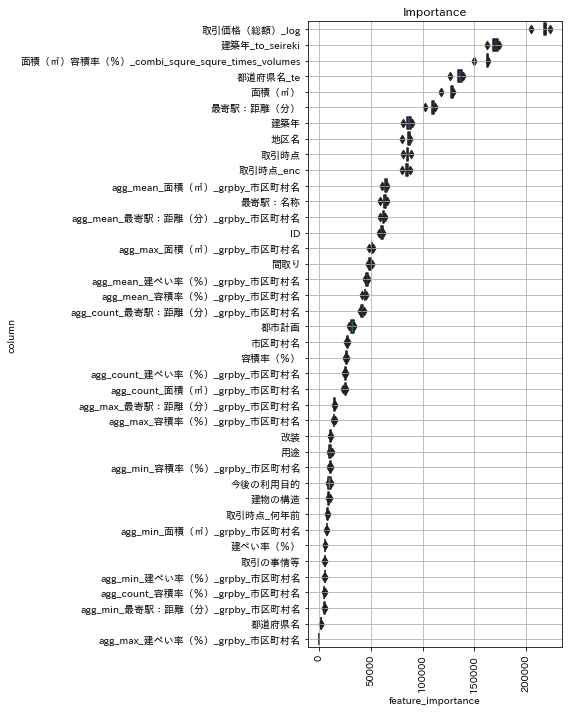

In [192]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_feat_df)

In [202]:
len(oof)/5

127470.2

In [200]:
test_feat_df.shape

(19466, 49)

In [203]:
train_feat_df.shape

(637351, 40)

In [197]:
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
# pred = revert_to_real(pred)
sub_df_hoge = sub_df.copy()
sub_df_hoge['取引価格（総額）_log'] = pred
sub_df_hoge.to_csv(os.path.join(OUTPUT_DIR, '0006__submission.csv'), index=False)

ValueError: Number of features of the model must match the input. Model n_features_ is 40 and input n_features is 49 

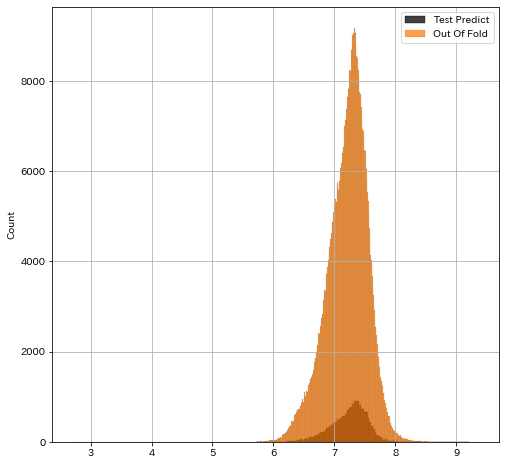

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(pred, label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()